In [1]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.cnn_rnn_hybrid_model import *
from utils.cnn_rnn_hybrid_utils import *
from utils.utils import *

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

## Hybrid Model with Last State sentence representation
Part 3.1 Accuracy: 0.7158, Part 3.2 Accuracy: 0.7477

In [8]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=2048,
    num_classes=1, # Binary classification
    kernel_size=3, # Size of the kernel for the CNN layer
    fc_hidden_dim=2048,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_method="last_state"
)

In [9]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

Epoch   1/100, Loss: 0.6938, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6917, Accuracy: 0.5394
Model saved.
Epoch   3/100, Loss: 0.6485, Accuracy: 0.6323
Model saved.
Epoch   4/100, Loss: 0.5434, Accuracy: 0.6792
Model saved.
Epoch   5/100, Loss: 0.4291, Accuracy: 0.6886
Model saved.
Epoch   6/100, Loss: 0.3258, Accuracy: 0.7045
Model saved.
Epoch   7/100, Loss: 0.2488, Accuracy: 0.6904
Epoch   8/100, Loss: 0.1886, Accuracy: 0.7045
Epoch   9/100, Loss: 0.1513, Accuracy: 0.6904
Epoch  10/100, Loss: 0.1127, Accuracy: 0.6932
Epoch  11/100, Loss: 0.0870, Accuracy: 0.6914
Epoch  12/100, Loss: 0.0809, Accuracy: 0.6867
Epoch  13/100, Loss: 0.0658, Accuracy: 0.6951
Epoch  14/100, Loss: 0.0598, Accuracy: 0.6979
Epoch  15/100, Loss: 0.0446, Accuracy: 0.7017
Epoch  16/100, Loss: 0.0461, Accuracy: 0.7026
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


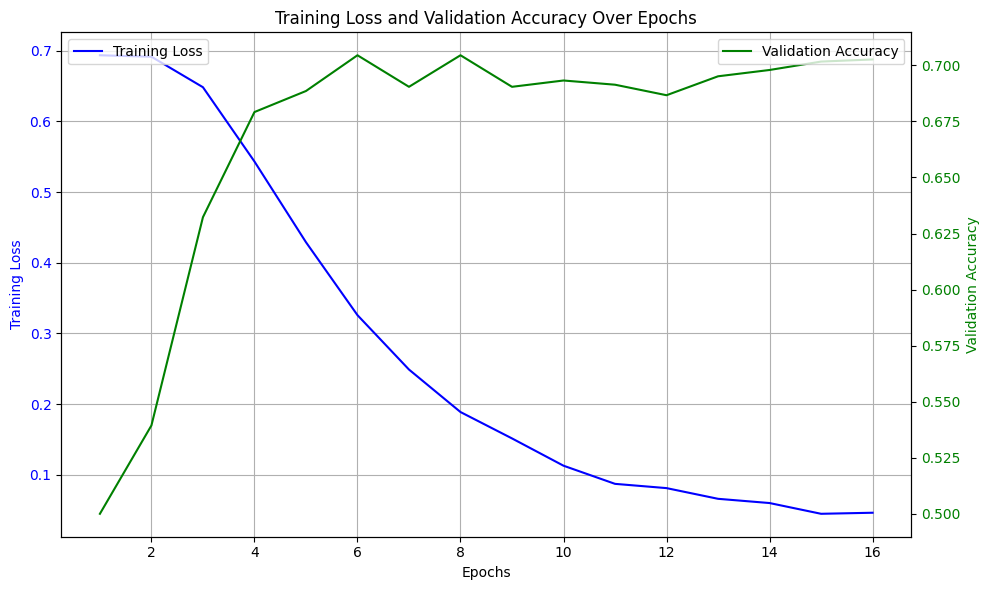

In [10]:
plot_training_progress(train_losses, val_accuracies)

In [11]:
last_state_rnn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7355


## Hybrid Model with Attention sentence representation
Part 3.1 Accuracy: 0.7083, Part 3.2 Accuracy: 0.7533

In [7]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=2048,
    num_classes=1,  # Binary classification
    kernel_size=3,  # Size of the kernel for the CNN layer
    fc_hidden_dim=2048,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
    pooling_method="attention"
)

In [8]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

Epoch   1/100, Loss: 0.6934, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6861, Accuracy: 0.5863
Model saved.
Epoch   3/100, Loss: 0.6131, Accuracy: 0.6623
Model saved.
Epoch   4/100, Loss: 0.5018, Accuracy: 0.6979
Model saved.
Epoch   5/100, Loss: 0.3935, Accuracy: 0.6904
Epoch   6/100, Loss: 0.3031, Accuracy: 0.7026
Model saved.
Epoch   7/100, Loss: 0.2347, Accuracy: 0.7120
Model saved.
Epoch   8/100, Loss: 0.1830, Accuracy: 0.6970
Epoch   9/100, Loss: 0.1494, Accuracy: 0.7036
Epoch  10/100, Loss: 0.1129, Accuracy: 0.7083
Epoch  11/100, Loss: 0.0957, Accuracy: 0.7073
Epoch  12/100, Loss: 0.0733, Accuracy: 0.7017
Epoch  13/100, Loss: 0.0647, Accuracy: 0.6951
Epoch  14/100, Loss: 0.0620, Accuracy: 0.6876
Epoch  15/100, Loss: 0.0492, Accuracy: 0.6839
Epoch  16/100, Loss: 0.0457, Accuracy: 0.6951
Epoch  17/100, Loss: 0.0372, Accuracy: 0.6989
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


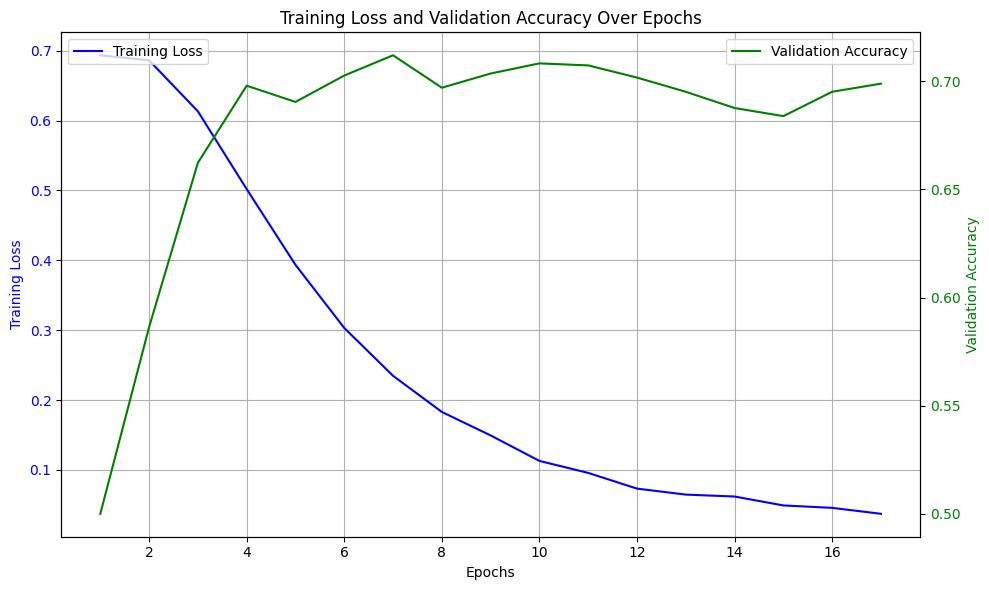

In [9]:
plot_training_progress(train_losses, val_accuracies)

In [10]:
attn_rnn_test_accuracy = validate(model, tst_dataloader)

Accuracy: 0.7270


# Results

In [13]:
print(f"CNN-RNN Hybrid model with Last State Test Accuracy: {last_state_rnn_test_accuracy:.4f}")
print(f"CNN-RNN Hybrid model with Attention Test Accuracy:  {attn_rnn_test_accuracy:.4f}")

CNN-RNN Hybrid model with Last State Test Accuracy: 0.7355
CNN-RNN Hybrid model with Attention Test Accuracy:  0.7270
